In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import utils
import config

In [3]:
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
    url = ["https://osf.io/agvxh/download"]
    url.append("https://osf.io/uv3mw/download")
    url.append("https://osf.io/ehmw2/download")

In [4]:
data=utils.load_data(fname)

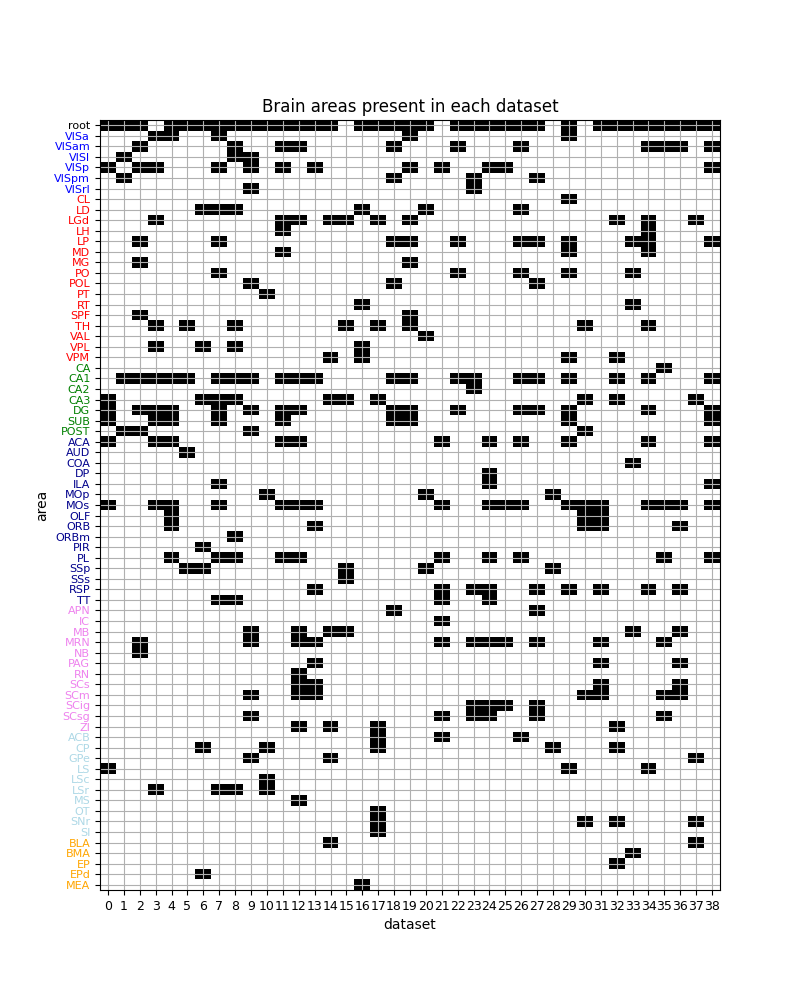

In [5]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in config.BRAIN_GROUPS:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(data)), dtype=bool)
for j, d in enumerate(data):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in config.BRAIN_GROUPS:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(data)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(config.BRAIN_GROUPS, config.REGION_COLORS):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

In [65]:
data[9]['spks'].shape # number of neurons by number of trials by time bins of 10 ms

(698, 340, 250)

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


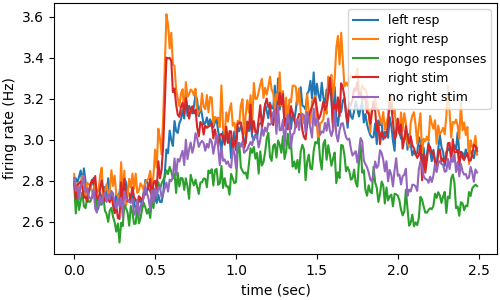

In [87]:
# select just one of the recordings here. 9 is nice because it has neurons in vis ctx.
dat = data[9]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

fig,ax = plt.subplots(figsize=(5, 3))
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response > 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response == 0].mean(axis=(0, 1)))  # nogo responses

plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp','nogo responses', 'right stim', 'no right stim'], fontsize=9)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

In [88]:
np.unique(dat['brain_area'])

array(['CA1', 'DG', 'GPe', 'MB', 'MRN', 'POL', 'POST', 'SCm', 'SCsg',
       'VISl', 'VISp', 'VISrl', 'root'], dtype='<U5')

In [89]:
nareas = 3  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = -1 * np.ones(NN, )  # -1 is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], config.BRAIN_GROUPS[j])] = j  # assign a number to each region

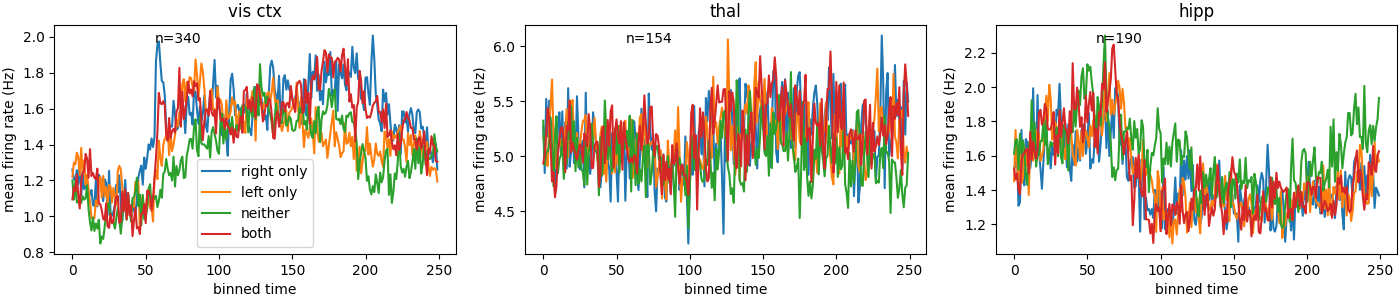

In [90]:
fig,ax = plt.subplots(nrows=1, ncols=nareas,figsize=(14,3))
for j in range(nareas):
  

  ax[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  ax[j].text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax[j].transAxes)
  if j==0:
    ax[j].legend(['right only', 'left only', 'neither', 'both'], fontsize=10)
  ax[j].set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=config.REGIONS[j])

fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

In [151]:
i_start = 0
i_end = 250
dat_right_left = np.reshape(dat['spks'][:, :, i_start:i_end], (NN, -1)) # from 100 ms before stimulus to 1.3s after stimulus   
print(dat_right_left.shape)
dat_right_left_z = utils.z_score(dat_right_left)#dat_right_left - np.mean(dat_right_left, axis=1)[:, np.newaxis]
model = PCA(n_components=5).fit(dat_right_left_z.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN, -1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))
pc_10ms.shape

(1172, 111750)


(5, 447, 250)

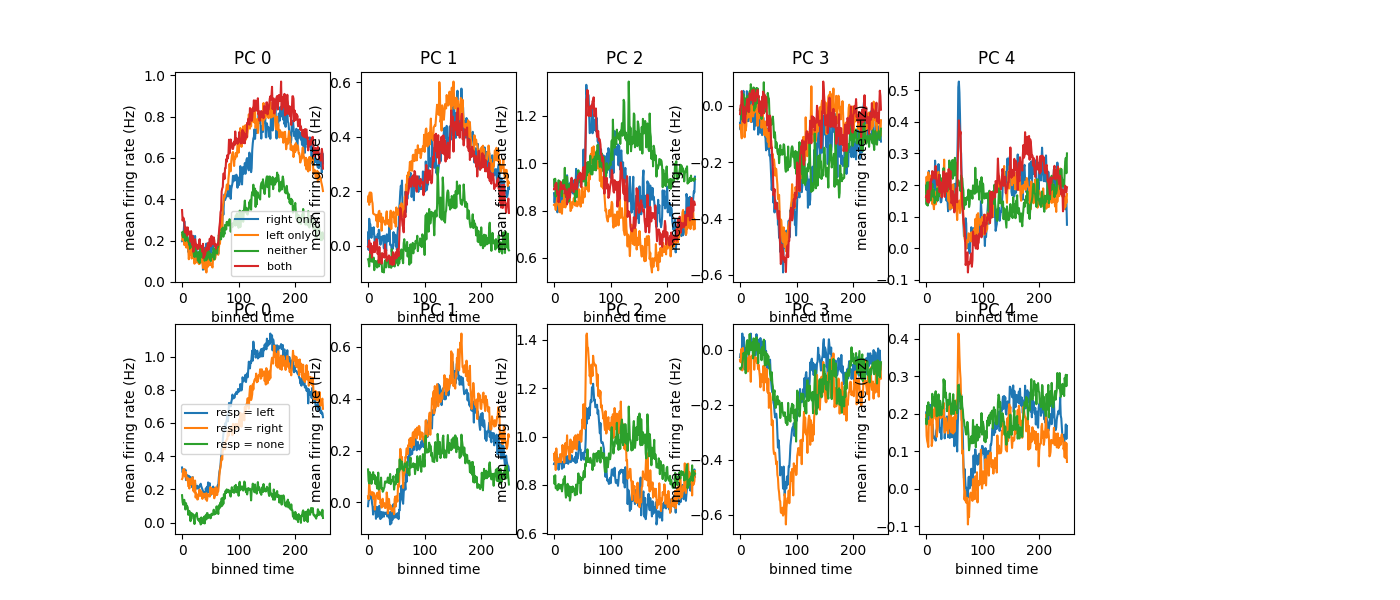

In [152]:
plt.figure(figsize= (14, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2, len(pc_10ms) + 1, j + 1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right > 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right > 0), :].mean(axis=0))

  if j == 0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2, len(pc_10ms) + 1, len(pc_10ms) + 1 + j + 1)

  plt.plot(pc1[response > 0, :].mean(axis=0))
  plt.plot(pc1[response < 0, :].mean(axis=0))
  plt.plot(pc1[response == 0, :].mean(axis=0))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)
plt.show()

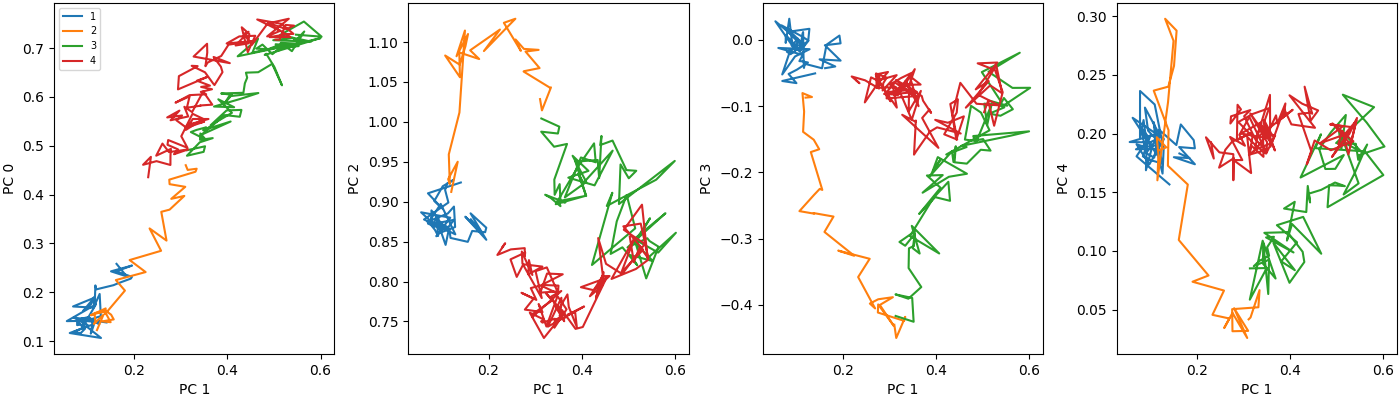

In [162]:
fig, ax = plt.subplots(nrows=1, ncols=len(pc_10ms)-1, figsize=(14,4))
#i_correct_ch =np.where(dat['feedback_type']==1)[0] # correct choices
pc_ind_v = [0,2,3,4]
pc_ind_h = 1
for nc in range(len(pc_10ms)-1):
    pc_j= pc_10ms[pc_ind_h]
    pc_j1=pc_10ms[pc_ind_v[nc]]
    ax[nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right == 0),0:51].mean(axis=0),pc_j1[:,0:51].mean(axis=0))
    ax[nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right == 0),51:83].mean(axis=0),pc_j1[:,51:83].mean(axis=0))
    ax[nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right == 0),83:153].mean(axis=0),pc_j1[:,83:153].mean(axis=0))
    ax[nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right == 0),153:].mean(axis=0),pc_j1[:,153:].mean(axis=0))

    ax[nc].set(xlabel = 'PC %d'%(pc_ind_h), ylabel='PC %d'%(pc_ind_v[nc]))

ax[0].legend(['1', '2', '3','4'], fontsize=7)
#ax[0][0].legend(['stim onset'], fontsize=8)
fig.tight_layout(pad=0.2, h_pad=1, w_pad=0.8)

## Select data from each area

In [93]:
regions=np.unique(barea)[1:] # the first value is -1 (other areas)
dat_area = utils.select_areas(regions=regions,data=dat,barea=barea)

## Compute PCA of each area

In [118]:
i_start = 51
i_end = [150,220,110]
area_i=0
num_comp = 5
all_pcs = []
for end,i_data in enumerate(dat_area):
    dat_t = i_data[:, :, i_start:i_end[end]] # from 100 ms before stimulus to 1.3s after stimulus   
    dat_t = np.reshape(dat_t, (dat_t.shape[0], -1))


    dat_t_z = dat_t - np.mean(dat_t, axis=1)[:, np.newaxis] #utils.z_score(dat_t)#
    model = PCA(n_components=num_comp).fit(dat_t_z.T)
    W = model.components_
    i_pc_area = W @ np.reshape(i_data, (i_data.shape[0], -1))
    i_pc_area = np.reshape(i_pc_area, (num_comp, -1, i_data.shape[-1]))
    all_pcs.append(i_pc_area)

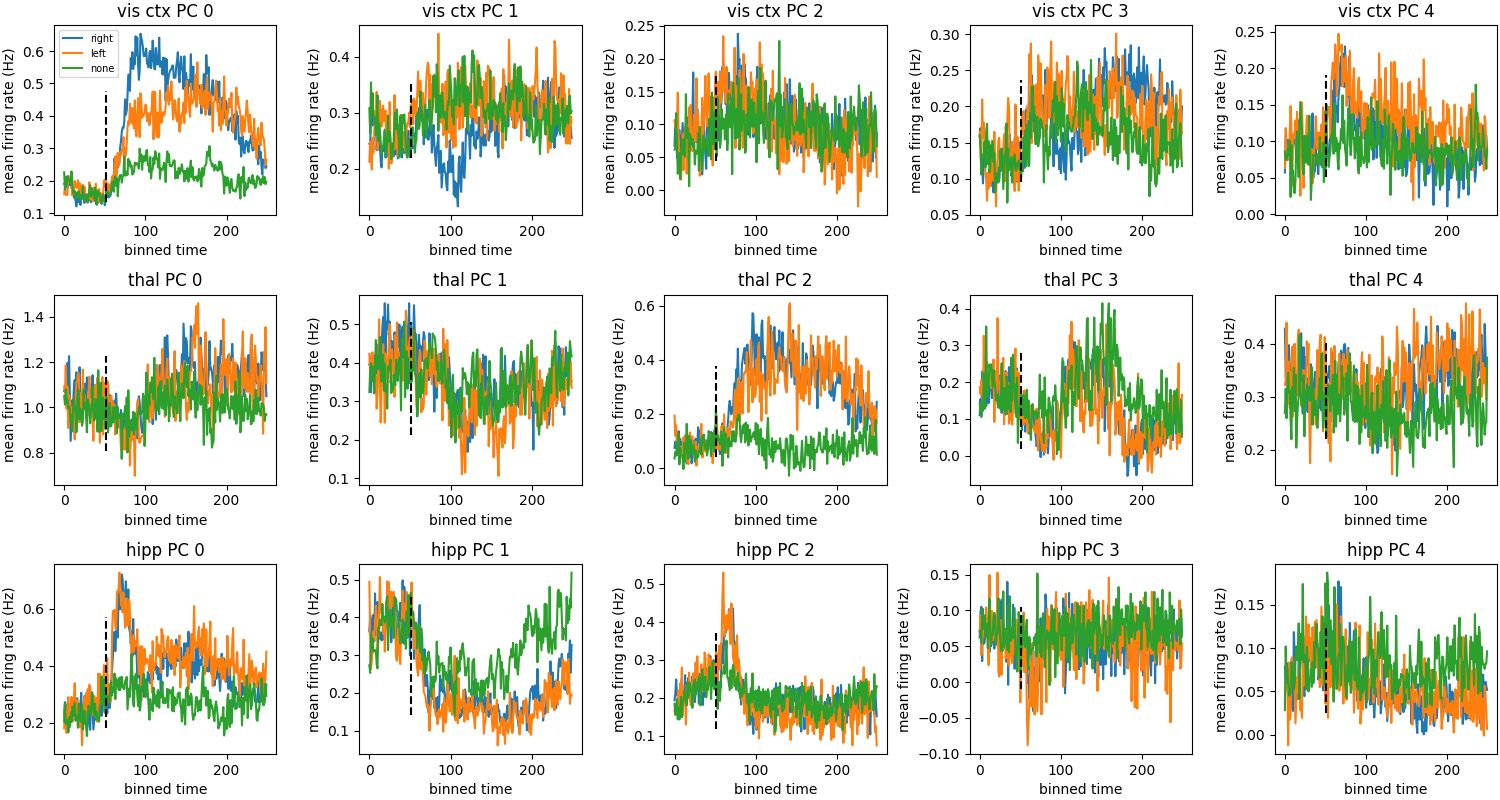

In [119]:
nrows=len(all_pcs)
ncols=5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
#i_correct_ch =np.where(dat['feedback_type']==1)[0] # correct choices
for nr,i_pc in enumerate(all_pcs):
  for nc,pc_j in enumerate(i_pc):
    
    ax[nr][nc].plot(pc_j[response > 0,:].mean(axis=0))
    ax[nr][nc].plot(pc_j[response<0,:].mean(axis=0))
    ax[nr][nc].plot(pc_j[response == 0,:].mean(axis=0))

    ax[nr][nc].vlines(51,np.min(pc_j.mean(axis=0)),np.max(pc_j.mean(axis=0)),colors='k',linestyles='dashed')
    ax[nr][nc].set(xlabel = 'binned time', ylabel='mean firing rate (Hz)',title='%s PC %d'%(config.REGIONS[nr],nc))

ax[0][0].legend(['right', 'left',  'none'], fontsize=7)
#ax[0][0].legend(['stim onset'], fontsize=8)
fig.tight_layout(pad=0.2, h_pad=1, w_pad=0.8)

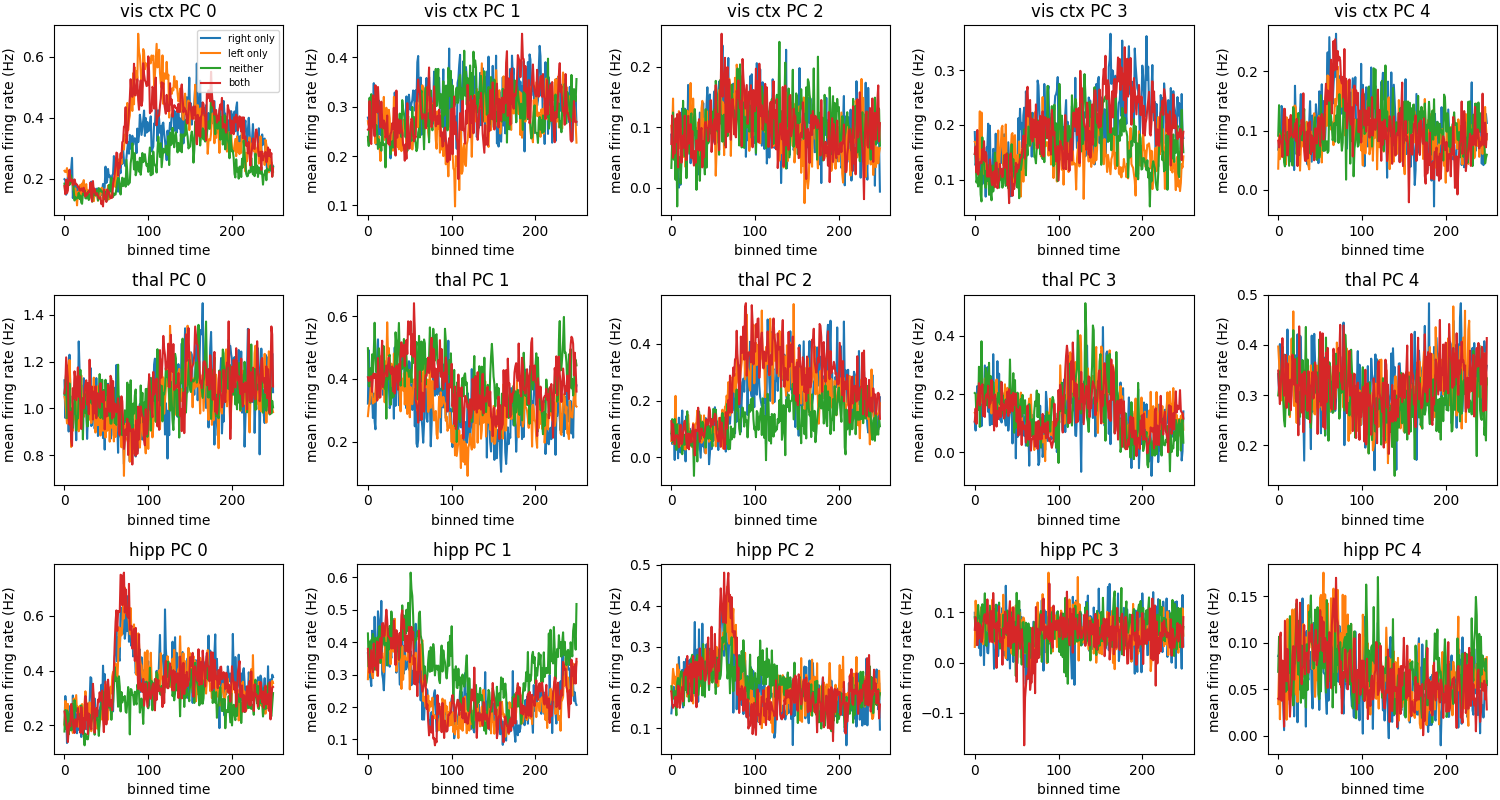

In [120]:
nrows=len(all_pcs)
ncols=5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
#i_correct_ch =np.where(dat['feedback_type']==1)[0] # correct choices
for nr,i_pc in enumerate(all_pcs):
  for nc,pc_j in enumerate(i_pc):

    #ax[nr][nc].plot(pc_j,color='b')
    #ax[nr][nc].vlines(51,np.min(pc_j.mean(axis=0)),np.max(pc_j.mean(axis=0)),colors='k',linestyles='dashed')
    ax[nr][nc].plot(pc_j[np.logical_and(vis_left == 0, vis_right > 0),:].mean(axis=0))
    ax[nr][nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right == 0),:].mean(axis=0))
    ax[nr][nc].plot(pc_j[np.logical_and(vis_left == 0, vis_right == 0),:].mean(axis=0))
    ax[nr][nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right > 0),:].mean(axis=0))

    ax[nr][nc].set(xlabel = 'binned time', ylabel='mean firing rate (Hz)',title='%s PC %d'%(config.REGIONS[nr],nc))


ax[0][0].legend(['right only', 'left only', 'neither', 'both'], fontsize=7)
#ax[0][0].legend(['stim onset'], fontsize=8)
fig.tight_layout(pad=0.2, h_pad=1, w_pad=0.8)

## pca solo vis c

In [121]:
np.unique(dat['brain_area'])

array(['CA1', 'DG', 'GPe', 'MB', 'MRN', 'POL', 'POST', 'SCm', 'SCsg',
       'VISl', 'VISp', 'VISrl', 'root'], dtype='<U5')

In [122]:
i_VISl=np.where(dat['brain_area']=='VISl')[0]
i_VISp=np.where(dat['brain_area']=='VISp')[0]
i_VISrl=np.where(dat['brain_area']=='VISrl')[0]

data_vis_cort = (dat['spks'][i_VISl],dat['spks'][i_VISp],dat['spks'][i_VISrl])

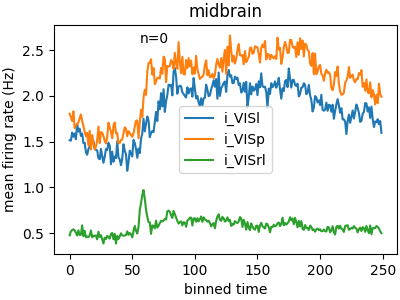

In [123]:
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(4,3)) 

ax.plot(1/dt * dat['spks'][i_VISl].mean(axis=(0, 1)))
ax.plot(1/dt * dat['spks'][i_VISp].mean(axis=(0, 1)))
ax.plot(1/dt * dat['spks'][i_VISrl].mean(axis=(0, 1)))

ax.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)
ax.legend(['i_VISl', 'i_VISp', 'i_VISrl'], fontsize=10)
ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=config.REGIONS[j])

fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

In [124]:
i_start = 51
i_end = [150,150,150]
area_i=0
num_comp = 5
all_pcs = []
for end,i_data in enumerate(data_vis_cort):
    dat_t = i_data[:, :, i_start:i_end[end]] # from 100 ms before stimulus to 1.3s after stimulus   
    dat_t = np.reshape(dat_t, (dat_t.shape[0], -1))


    dat_t_z = dat_t - np.mean(dat_t, axis=1)[:, np.newaxis] #utils.z_score(dat_t)#
    model = PCA(n_components=num_comp).fit(dat_t_z.T)
    W = model.components_
    i_pc_varea = W @ np.reshape(i_data, (i_data.shape[0], -1))
    i_pc_varea = np.reshape(i_pc_varea, (num_comp, -1, i_data.shape[-1]))
    all_pcs.append(i_pc_varea)

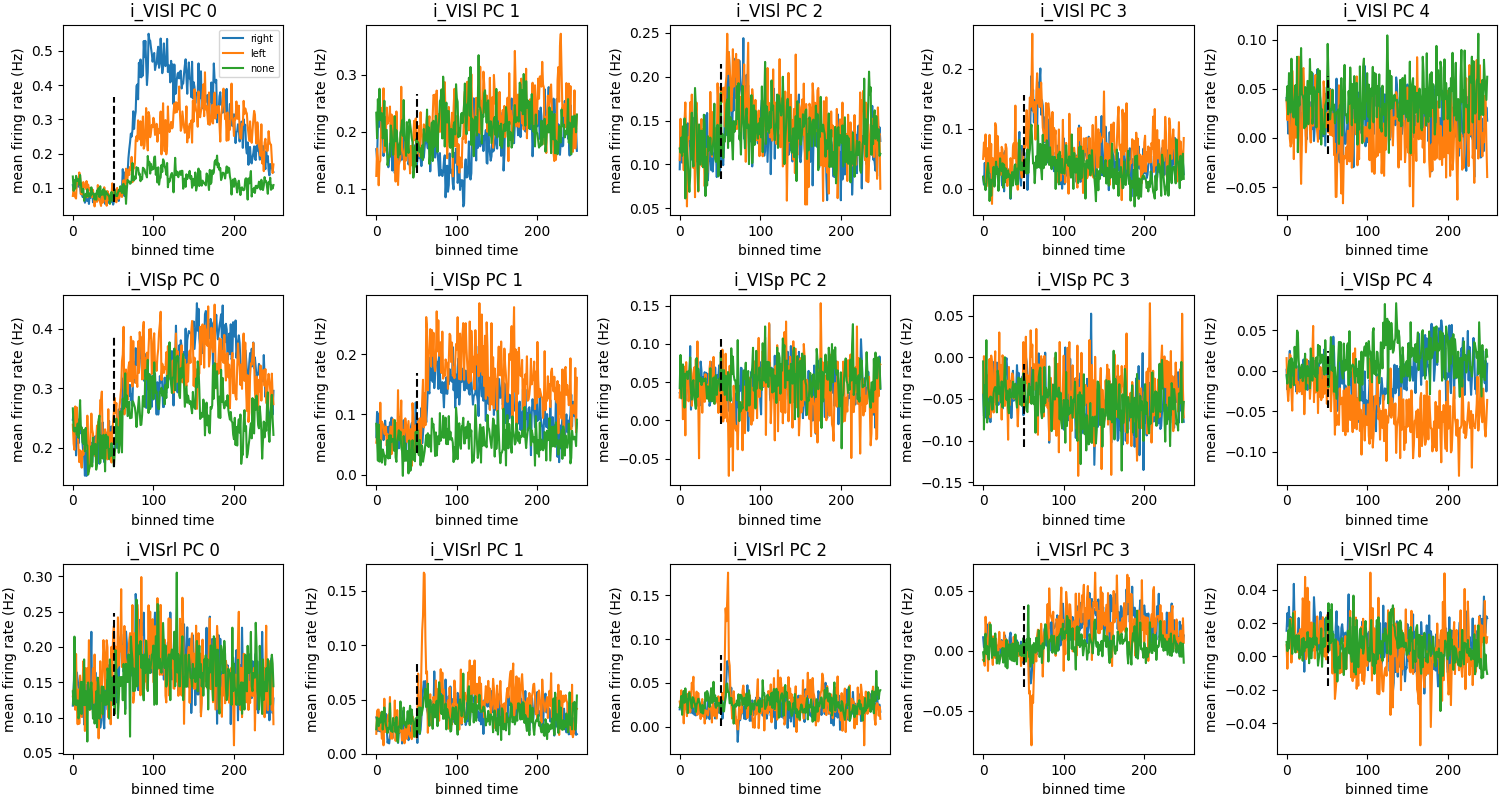

In [125]:
nrows=len(all_pcs)
ncols=5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
#i_correct_ch =np.where(dat['feedback_type']==1)[0] # correct choices
for nr,i_pc in enumerate(all_pcs):
  for nc,pc_j in enumerate(i_pc):
    
    ax[nr][nc].plot(pc_j[response > 0,:].mean(axis=0))
    ax[nr][nc].plot(pc_j[response<0,:].mean(axis=0))
    ax[nr][nc].plot(pc_j[response == 0,:].mean(axis=0))

    ax[nr][nc].vlines(51,np.min(pc_j.mean(axis=0)),np.max(pc_j.mean(axis=0)),colors='k',linestyles='dashed')
    ax[nr][nc].set(xlabel = 'binned time', ylabel='mean firing rate (Hz)',title='%s PC %d'%(('i_VISl', 'i_VISp', 'i_VISrl')[nr],nc))

ax[0][0].legend(['right', 'left',  'none'], fontsize=7)
#ax[0][0].legend(['stim onset'], fontsize=8)
fig.tight_layout(pad=0.2, h_pad=1, w_pad=0.8)



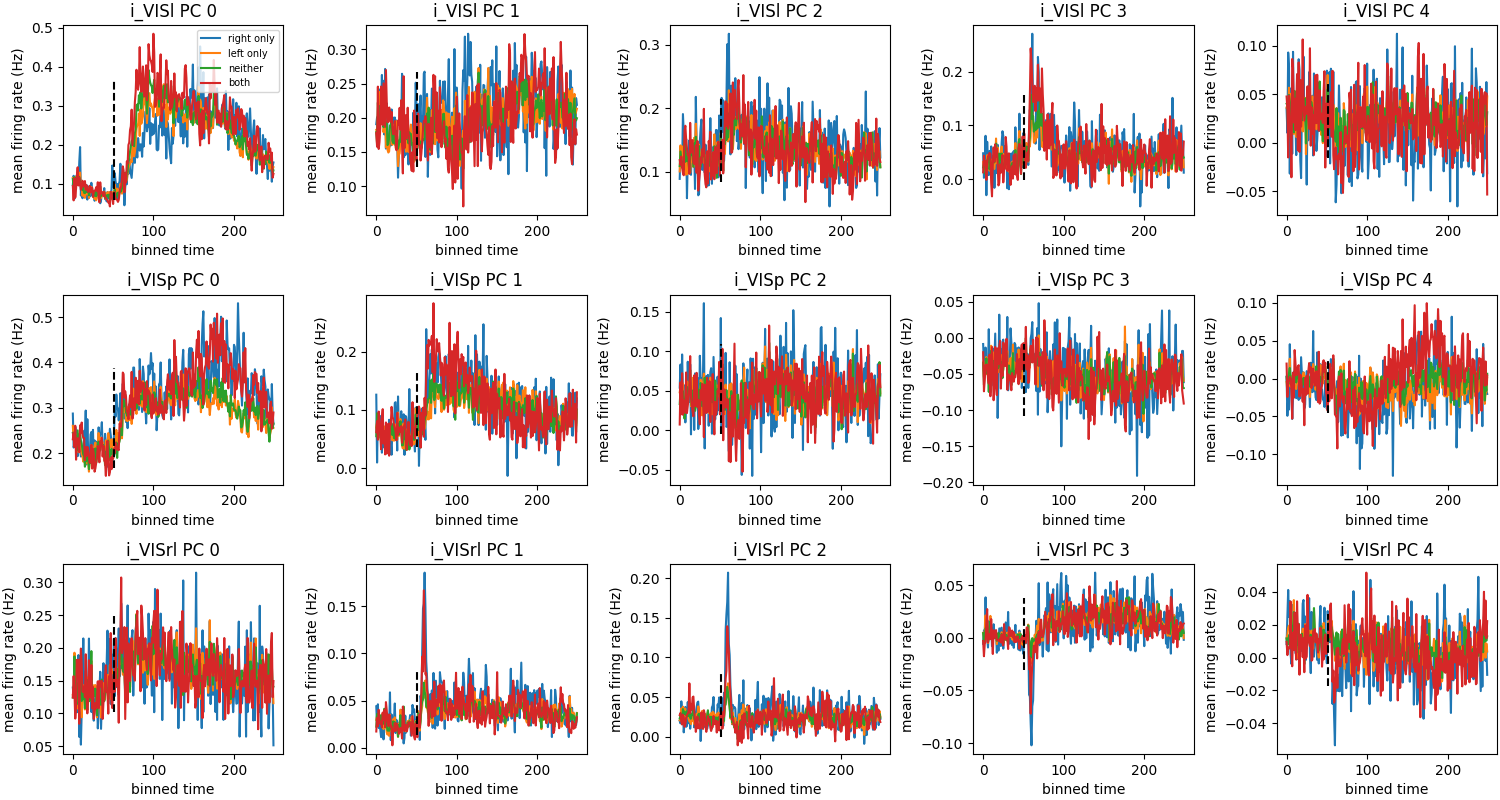

In [126]:
nrows=len(all_pcs)
ncols=5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
#i_correct_ch =np.where(dat['feedback_type']==1)[0] # correct choices
for nr,i_pc in enumerate(all_pcs):
  for nc,pc_j in enumerate(i_pc):


    ax[nr][nc].plot(pc_j[np.logical_and(vis_left == 0, vis_right) > 0,:].mean(axis=0))
    ax[nr][nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right) == 0,:].mean(axis=0))
    ax[nr][nc].plot(pc_j[np.logical_and(vis_left == 0, vis_right) == 0,:].mean(axis=0))
    ax[nr][nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right) > 0,:].mean(axis=0))

    ax[nr][nc].vlines(51,np.min(pc_j.mean(axis=0)),np.max(pc_j.mean(axis=0)),colors='k',linestyles='dashed')
    ax[nr][nc].set(xlabel = 'binned time', ylabel='mean firing rate (Hz)',title='%s PC %d'%(('i_VISl', 'i_VISp', 'i_VISrl')[nr],nc))

ax[0][0].legend(['right only', 'left only', 'neither', 'both'], fontsize=7)
#ax[0][0].legend(['stim onset'], fontsize=8)
fig.tight_layout(pad=0.2, h_pad=1, w_pad=0.8)
    
    


In [133]:
print(dat['gocue'].mean()/0.01)
print(dat['response_time'].mean()/0.01)

83.819248828541
153.65376539124273
